## Dataset Analysis

In [1]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(cwd), '.')) # Get the absolute path to the parent directory
sys.path.insert(0, parent_dir) # Add the parent directory to sys.path

In [2]:
dataset_dir = parent_dir + "/data" # root directory where to download the datasets
batch_size = 16
dataset_dir

'/home/joshua/Documents/phd/CompressionVAEHSI/data'

In [3]:
# loading datamodule
from src.data.bigearth_datamodule import BigEarthDataModule
dm = BigEarthDataModule(dataset_dir=dataset_dir, batch_size=batch_size, bands='all')
dm.setup()

In [5]:
dm.setup_folds(5)
dm.setup_fold_index(0)

batch = next(iter(dm.train_dataloader()))

In [10]:
x, y = batch.values()

In [12]:
dm.maxs

tensor([6.0000e+00, 1.6000e+01, 9.8590e+03, 1.2872e+04, 1.3163e+04, 1.4445e+04,
        1.2477e+04, 1.2563e+04, 1.2289e+04, 1.5596e+04, 1.2183e+04, 9.4580e+03,
        5.8970e+03, 5.5440e+03])

In [14]:
# loading dataset
from src.data.bigearth_dataset import BigEarthDataset
data = BigEarthDataset(                                                                                                                                                                                                                         
    root=dataset_dir,
    bands='all',
    download=False,
)

In [21]:
data.folders[0]

{'s1': '/home/joshua/Documents/phd/CompressionVAEHSI/data/BigEarthNet-S1-v1.0/S1B_IW_GRDH_1SDV_20170717T064605_29UPA_28_87',
 's2': '/home/joshua/Documents/phd/CompressionVAEHSI/data/BigEarthNet-v1.0/S2A_MSIL2A_20170717T113321_28_87'}

In [9]:
filename = "master.csv"

In [24]:
import pandas as pd
master = pd.read_csv(dataset_dir+'/'+filename)

In [26]:
names = master.columns
names

Index(['S2', 'S1'], dtype='object')

In [22]:
master

,0,1
0,S2,S1
1,S2A_MSIL2A_20170717T113321_28_87,S1B_IW_GRDH_1SDV_20170717T064605_29UPA_28_87
2,S2A_MSIL2A_20170717T113321_28_90,S1B_IW_GRDH_1SDV_20170717T064605_29UPA_28_90
3,S2A_MSIL2A_20170717T113321_29_83,S1B_IW_GRDH_1SDV_20170717T064605_29UPA_29_83
4,S2A_MSIL2A_20170717T113321_29_84,S1B_IW_GRDH_1SDV_20170717T064605_29UPA_29_84
...,...,...
519280,S2B_MSIL2A_20170924T93021_74_7,S1B_IW_GRDH_1SDV_20170926T042416_35VPH_74_7
519281,S2B_MSIL2A_20180522T093029_72_6,S1B_IW_GRDH_1SDV_20180524T153951_35VPH_72_6
519282,S2B_MSIL2A_20180522T093029_74_7,S1B_IW_GRDH_1SDV_20180524T153951_35VPH_74_7
519283,S2B_MSIL2A_20170812T092029_72_6,S1A_IW_GRDH_1SDV_20170810T153207_35VPH_72_6


In [19]:
master.columns = {'S2', 'S1'}

In [26]:
master.to_csv(os.path.join(parent_dir, filename), index=False)

In [23]:
s1_dir = 'BigEarthNet-S1-v1.0'
s2_dir = 'BigEarthNet-v1.0'

#s2 = master['S2'].tolist()
#s1 = master['S1'].tolist()

folders = [
            {
                "s1": os.path.join(parent_dir, s1_dir, s1_file),
                "s2": os.path.join(parent_dir, s2_dir, s2_file)
            }
    for s1_file, s2_file in zip(master['S1'], master['S2'])
]

In [25]:
folders[0]

{'s1': '/home/joshua/Documents/phd/CompressionVAEHSI/BigEarthNet-S1-v1.0/S1B_IW_GRDH_1SDV_20170717T064605_29UPA_28_87',
 's2': '/home/joshua/Documents/phd/CompressionVAEHSI/BigEarthNet-v1.0/S2A_MSIL2A_20170717T113321_28_87'}

In [4]:
dm.setup_folds(5)
dm.setup_fold_index(0)
print("Number of train samples: ", len(dm.train_dataloader().dataset))
print("Number of validation samples: ", len(dm.val_dataloader().dataset))
print("Number of test samples: ", len(dm.test_dataloader().dataset))

Number of train samples:  332342
Number of validation samples:  83086
Number of test samples:  103857


In [6]:
batch = next(iter(dm.train_dataloader()))
x, y = batch.values()

In [50]:
batch['image'].shape

torch.Size([16, 12, 120, 120])

In [32]:
import matplotlib.pyplot as plt
import numpy as np

#TODO for reconstruction images we need the one-hot class decoder
def get_label_names(onehots, class_names):
    """get all the names when a label is a one-hot."""
    label_idx = np.where(onehots)[0]
    label_names = [class_names[19][idx] for idx in label_idx]
    return label_names

def display_image(ds, idx):
    #img = ds[idx]['data'].numpy()
    img = ds[idx]['image'].numpy()[3:6,:,:]
    labels = ds[idx]['label']
    for band in range(len(img)):
        # normalize based on min/max pixel values to clamp ranges in [0, 1]
        img[band, ...] = (img[band, ...] - np.min(img[band, ...])) / np.max(img[band, ...])
    
    img = np.moveaxis(img, 0, 2) # C, W, H > W, H, C
    img = img[:,:,::-1] # BGR to RGB
    
    label_names = get_label_names(labels, dm.label_decoder) 

    plt.title('\n'.join(label_names))
    plt.imshow(img)
    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

In [115]:
img = np.moveaxis(orig_img, 0, 2) # switchs from [14,120,120] to [120,120,14]
img.shape

(120, 120, 3)

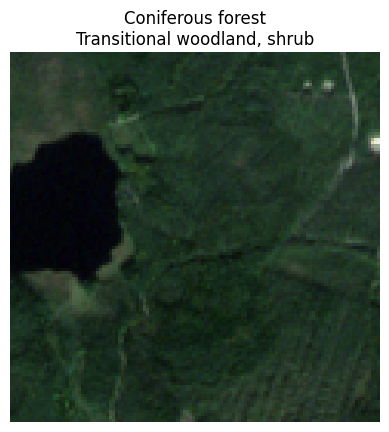

In [33]:
ds = dm.val_dataloader().dataset
display_image(ds, 5)